In [1]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve, GridSearchCV, learning_curve
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as Img
import os
%matplotlib inline

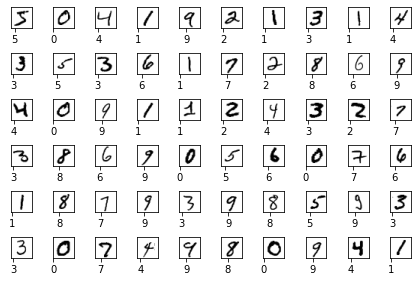

In [2]:
# Набор цифр MNIST

(train_X, train_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()

# Подграфики

fig, ax = plt.subplots(6, 10) # первые 60 цифр

# Рисуем графики цифр

for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(train_X[i], origin='upper', cmap='binary')
    ax_i.set(xticks=[train_y[i]], yticks=[])
plt.tight_layout()

In [3]:
# Препроцессинг данных для обучения

train_X = train_X/train_X.max()

X = np.empty((60000, 784))
k = 0
for i in range(28):
    for j in range(28):
        X[:, k] = train_X[:, i, j]
        k += 1
        
# Препроцессинг данных для тестирования

test_X = test_X/test_X.max()

T = np.empty((10000, 784))
k = 0
for i in range(28):
    for j in range(28):
        T[:, k] = test_X[:, i, j]
        k += 1

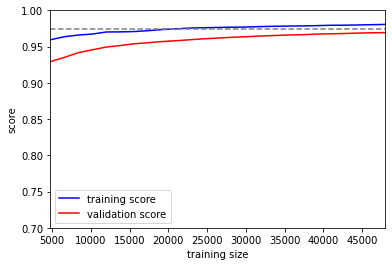

In [4]:
# Кривая обучения. Перекрестная проверка результатов обучения и тестирования для разного числа элементов выборки
# Примерное время выполнения этой ячейки - 30 минут!

sizes, training_scores, testing_scores = learning_curve(
                    KNeighborsClassifier(), X, train_y, cv=5,
                    scoring='accuracy',
                    train_sizes=np.linspace(0.1, 1.0, 25)
                    )

plt.plot(sizes, np.mean(training_scores, 1), color='blue', label='training score')
plt.plot(sizes, np.mean(testing_scores, 1), color='red', label='validation score')
plt.hlines(
        np.mean([training_scores[-1], testing_scores[-1]]),
        sizes[0], sizes[-1],
        color='gray',
        linestyle='dashed'
        )
plt.ylim(0.7, 1)
plt.xlim(sizes[0], sizes[-1])
plt.xlabel('training size')
plt.ylabel('score')
plt.legend(loc='best')

In [5]:
# Обучение выше 25000 существенную эффективность не принесёт, обучим на 25000, но сначала найдём оптимальное число соседей 

model = KNeighborsClassifier()
k_range = list(range(1, 18))
param_grid = dict(n_neighbors=k_range, weights=['uniform', 'distance'])

grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy',
                    return_train_score=False, verbose=1)

grid_search = grid.fit(X[:25000], train_y[:25000])
print(grid_search.best_params_)

Fitting 5 folds for each of 34 candidates, totalling 170 fits
{'n_neighbors': 4, 'weights': 'distance'}


96.21%


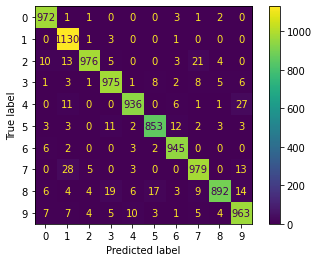

In [6]:
# Обучим модель на 25000 цифрах с четырьмя соседями, найдём эффективность предсказания и построим матрицу ошибок

model = KNeighborsClassifier(n_neighbors=4, weights='distance')
model.fit(X[:25000], train_y[:25000])
model_y = model.predict(T)
print('{0:.2%}'.format(accuracy_score(test_y, model_y)))
ConfusionMatrixDisplay.from_estimator(model, T[:25000], test_y[:25000])

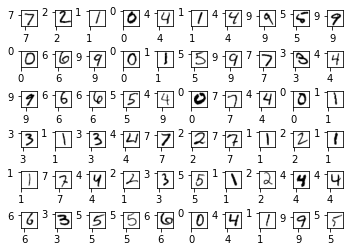

In [7]:
# Подграфики

fig.clear()
fig, ax = plt.subplots(6, 10)
plt.subplots_adjust(hspace=1.5)

# Рисуем графики

for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(test_X[i], origin='upper', cmap='binary')
    ax_i.set(xticks=[model_y[i]], yticks=[test_y[i]])
    
# Слева от цифры её истинное значение, снизу - предсказанное значение

In [9]:
# Мои цифры, файлы находятся в Desktop/figures

from IPython.display import Image, display
for imageName in os.listdir('Desktop/figures'):
    display(Image(filename='Desktop/figures/' + imageName))

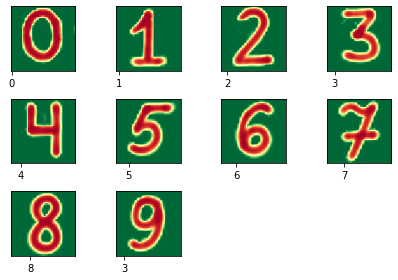

In [10]:
# Препроцессинг моих цифр

n = 0
imX = np.empty((10, 784), dtype='int16')
for img_i in os.listdir('Desktop/figures'):
    sample = Img.open('Desktop/figures/'+ img_i)
    k = 0
    for i in range(28):
        for j in range(28):
            imX[n, k] = sample.getpixel((j, i))[0]
            k += 1
    sample.close()
    n += 1

img = np.empty((10, 28, 28), dtype='int32')
k = 0
while (k < 784):
    for i in range(28):
        for j in range(28):
            img[:, i, j] = imX[:, k]
            k += 1
            
imX = imX/imX.max()

# Предсказание моих цифр

result = model.predict(imX)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(3, 4, i)
    ax.imshow(img[i-1], origin='upper', cmap='RdYlGn_r')
    ax.set(xticks=[result[i-1]], yticks=[])
plt.tight_layout()

# Правильно предсказано: 9 из 10 цифр